In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from scipy.stats import \
(ttest_1samp,
ttest_rel,
ttest_ind,
t as t_dbn)
from statsmodels.stats.multicomp import \
pairwise_tukeyhsd
from statsmodels.stats.multitest import \
multipletests as mult_test
from ISLP.models import (ModelSpec as MS,
summarize,
poly)

In [ ]:
#13.6 Lab: Multiple Testing

In [ ]:
#13.6.1 Review of Hypothesis Tests

In [2]:
#First we create 100 variables, each consisting of 10 observations. The frst 50 variables have mean 0.5 and variance 1, 
#while the others have mean 0 and variance 1.
rng = np.random.default_rng(12)
X = rng.standard_normal((10, 100))
true_mean = np.array([0.5]*50 + [0]*50)
X += true_mean[None,:]

In [3]:
#test H0 : µ1 = 0, the null hypothesis that the first variable has mean zero.
result = ttest_1samp(X[:,0], 0)
result.pvalue

0.9307442156164141

In [4]:
# test H0,j : µj = 0 for j = 1,..., 100
# compute the 100 pvalues, and then construct a vector recording whether the jth p-value is less than or equal to 0.05
p_values = np.empty(100)
for i in range(100):
    p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values,
                  [0, 0.05, 1],
                  labels=['Reject H0',
                          'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                       categories=[True, False],
                       ordered=True)

In [5]:
pd.crosstab(decision,
            truth,
            rownames=['Decision'],
            colnames=['H0'])

H0,True,False
Decision,,
Reject H0,5,15
Do not reject H0,45,35


In [ ]:
#Therefore, at level α = 0.05, we reject 15 of the 50 false null hypotheses, and we incorrectly reject 5 of the true null hypotheses.

In [6]:
# simulate data with a stronger signal, so that the ratio of the mean to the standard deviation for the false null hypotheses equals 1.
# We make only 10 Type II errors.
true_mean = np.array([1]*50 + [0]*50)
X = rng.standard_normal((10, 100))
X += true_mean[None,:]
for i in range(100):
    p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values,
                  [0, 0.05, 1],
                  labels=['Reject H0',
                          'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                       categories=[True, False],
                       ordered=True)
pd.crosstab(decision,
            truth,
            rownames=['Decision'],
            colnames=['H0'])

H0,True,False
Decision,,
Reject H0,2,40
Do not reject H0,48,10


In [ ]:
#13.6.2 Family-Wise Error Rate

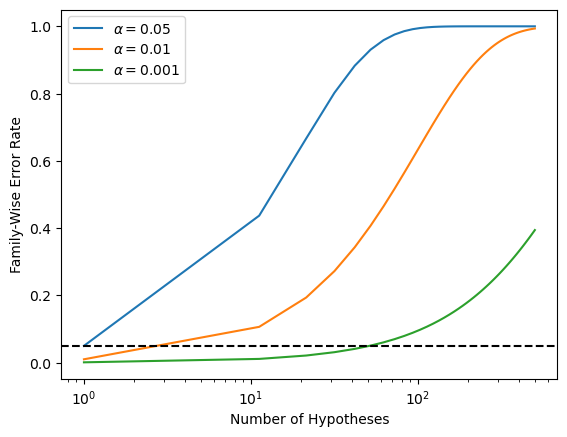

In [7]:
#FWER is equal to 1 − (1 − α)m
m = np.linspace(1, 501)
fig, ax = plt.subplots()
[ax.plot(m,
         1 - (1 - alpha)**m,
         label=r'$\alpha=%s$' % str(alpha)) 
         for alpha in [0.05, 0.01, 0.001]]
ax.set_xscale('log')
ax.set_xlabel('Number of Hypotheses')
ax.set_ylabel('Family-Wise Error Rate')
ax.legend()
ax.axhline(0.05, c='k', ls='--');

In [ ]:
#even for moderate values of m such as 50, the FWER exceeds 0.05 unless α is set to a very low value, such as 0.001.

In [8]:
#a one-sample t-test for each of the frst fve managers in the Fund dataset
Fund = load_data('Fund')
fund_mini = Fund.iloc[:,:5]
fund_mini_pvals = np.empty(5)
for i in range(5):
    fund_mini_pvals[i] = ttest_1samp(fund_mini.iloc[:,i], 0).pvalue
fund_mini_pvals

array([0.00620236, 0.91827115, 0.01160098, 0.6005396 , 0.75578151])

In [9]:
#conduct Bonferroni’s method
reject, bonf = mult_test(fund_mini_pvals, method = "bonferroni")[:2]
reject

array([ True, False, False, False, False])

In [ ]:
#The p-values bonf are simply the fund_mini_pvalues multiplied by 5 and truncated to be less than or equal to 1.

In [10]:
bonf, np.minimum(fund_mini_pvals * 5, 1)

(array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ]),
 array([0.03101178, 1.        , 0.05800491, 1.        , 1.        ]))

In [ ]:
#Therefore, using Bonferroni’s method, we are able to reject the null hypothesis only for Manager One while controlling FWER at 0.05.

In [11]:
#Holm’s method, the adjusted p-values indicate that we can reject the null hypotheses for Managers One and Three at a FWER of 0.05.
mult_test(fund_mini_pvals, method = "holm", alpha=0.05)[:2]

(array([ True, False,  True, False, False]),
 array([0.03101178, 1.        , 0.04640393, 1.        , 1.        ]))

In [12]:
fund_mini.mean()

Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64

In [13]:
#performing a paired t-test
ttest_rel(fund_mini['Manager1'],
          fund_mini['Manager2']).pvalue

0.038391072368079586

In [ ]:
#The test results in a p-value of 0.038, suggesting a statistically signifcant diference.

In [ ]:
#apply Tukey’s method in order to adjust for multiple testing

In [14]:
returns = np.hstack([fund_mini.iloc[:,i] for i in range(5)])
managers = np.hstack([[i+1]*50 for i in range(5)])
tukey = pairwise_tukeyhsd(returns, managers)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2     -3.1 0.1862 -6.9865 0.7865  False
     1      3     -0.2 0.9999 -4.0865 3.6865  False
     1      4     -2.5 0.3948 -6.3865 1.3865  False
     1      5     -2.7 0.3152 -6.5865 1.1865  False
     2      3      2.9 0.2453 -0.9865 6.7865  False
     2      4      0.6 0.9932 -3.2865 4.4865  False
     2      5      0.4 0.9986 -3.4865 4.2865  False
     3      4     -2.3  0.482 -6.1865 1.5865  False
     3      5     -2.5 0.3948 -6.3865 1.3865  False
     4      5     -0.2 0.9999 -4.0865 3.6865  False
---------------------------------------------------


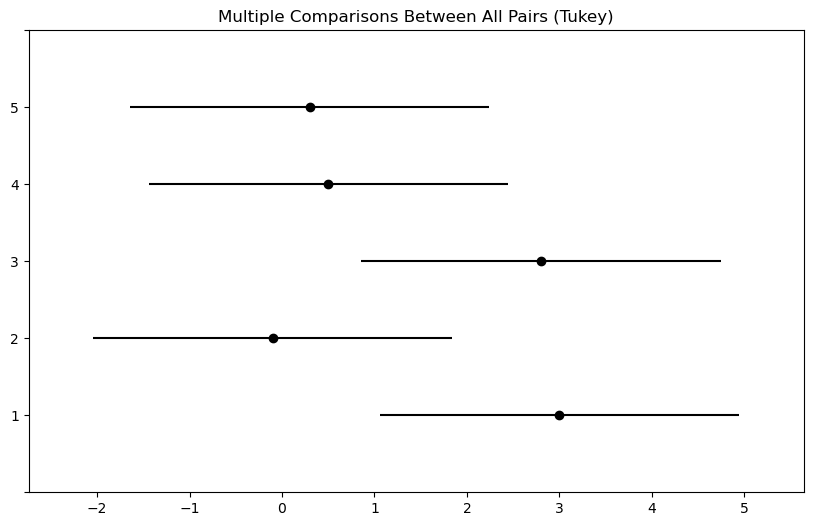

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
tukey.plot_simultaneous(ax=ax);

In [ ]:
#13.6.3 False Discovery Rate

In [16]:
#perform hypothesis tests for all 2,000 fund managers in the Fund dataset.
fund_pvalues = np.empty(2000)
for i, manager in enumerate(Fund.columns):
    fund_pvalues[i] = ttest_1samp(Fund[manager], 0).pvalue

In [17]:
#controlling the FDR
fund_qvalues = mult_test(fund_pvalues, method = "fdr_bh")[1]
fund_qvalues[:10]

array([0.08988921, 0.991491  , 0.12211561, 0.92342997, 0.95603587,
       0.07513802, 0.0767015 , 0.07513802, 0.07513802, 0.07513802])

In [ ]:
#q-values output by the Benjamini–Hochberg procedure can be interpreted as the smallest FDR threshold 
#at which we would reject a particular null hypothesis.

In [18]:
#If we control the FDR at 10%
#We find that 146 of the 2,000 fund managers have a q-value below 0.1;
#therefore, we are able to conclude that 146 of the fund managers beat the market at an FDR of 10%. 
#Only about 15 (10% of 146) of these fund managers are likely to be false discoveries.
(fund_qvalues <= 0.1).sum()

146

In [19]:
#used Bonferroni’s method to control the FWER at level α = 0.1
(fund_pvalues <= 0.1 / 2000).sum()
#then we would have failed to reject any null hypotheses

0

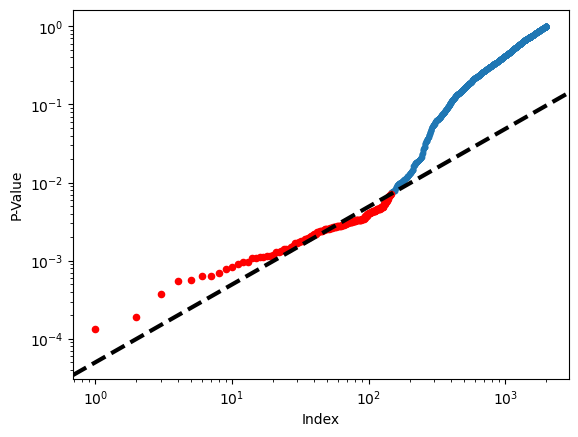

In [21]:
# implement the Benjamini–Hochberg procedure ourselves, in order to illustrate how it works.
sorted_ = np.sort(fund_pvalues)
m = fund_pvalues.shape[0]
q = 0.1
sorted_set_ = np.where(sorted_ < q * np.linspace(1, m, m) / m)[0]
if sorted_set_.shape[0] > 0:
    selected_ = fund_pvalues < sorted_[sorted_set_].max()
    sorted_set_ = np.arange(sorted_set_.max())
else:
    selected_ = []
    sorted_set_ = []

fig, ax = plt.subplots()
ax.scatter(np.arange(0, sorted_.shape[0]) + 1,
sorted_, s=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('P-Value')
ax.set_xlabel('Index')
ax.scatter(sorted_set_+1, sorted_[sorted_set_], c='r', s=20)
ax.axline((0, 0), (1,q/m), c='k', ls='--', linewidth=3);

In [ ]:
#When the FDR is controlled at level q = 0.1, 146 null hypotheses are rejected

In [ ]:
#13.6.4 A Re-Sampling Approach

In [23]:
#merge the training and testing data
#results in observations on 83 patients for 2,308 genes.
Khan = load_data('Khan')
D = pd.concat([Khan['xtrain'], Khan['xtest']])
D['Y'] = pd.concat([Khan['ytrain'], Khan['ytest']])
D['Y'].value_counts()

2    29
4    25
3    18
1    11
Name: Y, dtype: int64

In [24]:
# For each gene, we compare the mean expression in the second class (rhabdomyosarcoma) to the mean expression in
#the fourth class (Burkitt’s lymphoma). Performing a standard two-sample t-test
D2 = D[lambda df:df['Y'] == 2]
D4 = D[lambda df:df['Y'] == 4]
gene_11 = 'G0011'
observedT, pvalue = ttest_ind(D2[gene_11],
                              D4[gene_11],
                              equal_var=True)
observedT, pvalue

(-2.0936330736768185, 0.04118643782678394)

In [ ]:
#Performing a standard two-sample t-test on the 11th gene produces a
#test-statistic of -2.09 and an associated p-value of 0.0412, suggesting 
#modest evidence of a diference in mean expression levels between the two cancer types.

In [ ]:
#However, this p-value relies on the assumption that under the null hypothesis of no diference between the two groups, the test statistic follows a t-distribution with 29 + 25 − 2 = 52 degrees of freedom.

In [25]:
#Under the null hypothesis of no diference between the groups, this new test statistic should have the same distribution as our original one.
#Repeating this process 10,000 times allows us to approximate the null distribution of the
#test statistic. We compute the fraction of the time that our observed test statistic exceeds the test statistics obtained via re-sampling.
B = 10000
Tnull = np.empty(B)
D_ = np.hstack([D2[gene_11], D4[gene_11]])
n_ = D2[gene_11].shape[0]
D_null = D_.copy()
for b in range(B):
    rng.shuffle(D_null)
    ttest_ = ttest_ind(D_null[:n_],
                       D_null[n_:],
                       equal_var=True)
    Tnull[b] = ttest_.statistic
(np.abs(Tnull) > np.abs(observedT)).mean()

0.0398

In [ ]:
#This fraction, 0.0398, is our re-sampling-based p-value. It is almost identical to the p-value of 0.0412 obtained using the theoretical null distribution.

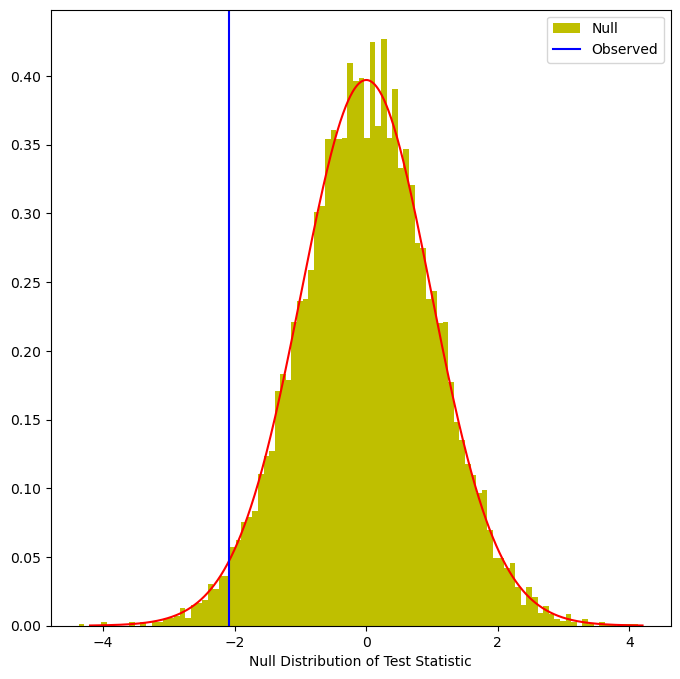

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(Tnull,
        bins=100,
        density=True,
        facecolor='y',
        label='Null')
xval = np.linspace(-4.2, 4.2, 1001)
ax.plot(xval,
        t_dbn.pdf(xval, D_.shape[0]-2),
        c='r')
ax.axvline(observedT,
           c='b',
           label='Observed')
ax.legend()
ax.set_xlabel("Null Distribution of Test Statistic");

In [28]:
#implement the plug-in re-sampling FDR approach outlined in Algorithm 13.4
m, B = 100, 10000
idx = rng.choice(Khan['xtest'].columns, m, replace=False)
T_vals = np.empty(m)
Tnull_vals = np.empty((m, B))
for j in range(m):
    col = idx[j]
    T_vals[j] = ttest_ind(D2[col],
                          D4[col],
                          equal_var=True).statistic
    D_ = np.hstack([D2[col], D4[col]])
    D_null = D_.copy()
    for b in range(B):
        rng.shuffle(D_null)
        ttest_ = ttest_ind(D_null[:n_],
                           D_null[n_:],
                           equal_var=True)
        Tnull_vals[j,b] = ttest_.statistic

In [29]:
#compute the number of rejected null hypotheses R, the estimated number of false positives W V , and the estimated FDR, for a range
#of threshold values c in Algorithm 13.4.
cutoffs = np.sort(np.abs(T_vals))
FDRs, Rs, Vs = np.empty((3, m))
for j in range(m):
    R = np.sum(np.abs(T_vals) >= cutoffs[j])
    V = np.sum(np.abs(Tnull_vals) >= cutoffs[j]) / B
    Rs[j] = R
    Vs[j] = V
    FDRs[j] = V / R

In [30]:
#The variable idx stores which genes were included in our 100 randomlyselected genes. Let’s look at the genes whose estimated FDR is less than 0.1.
sorted(idx[np.abs(T_vals) >= cutoffs[FDRs < 0.1].min()])

['G0097',
 'G0129',
 'G0182',
 'G0714',
 'G0812',
 'G0941',
 'G0982',
 'G1020',
 'G1022',
 'G1090',
 'G1320',
 'G1634',
 'G1697',
 'G1853',
 'G1854',
 'G1994',
 'G2017',
 'G2115',
 'G2193']

In [31]:
sorted(idx[np.abs(T_vals) >= cutoffs[FDRs < 0.2].min()])

['G0097',
 'G0129',
 'G0158',
 'G0182',
 'G0242',
 'G0552',
 'G0679',
 'G0714',
 'G0751',
 'G0812',
 'G0908',
 'G0941',
 'G0982',
 'G1020',
 'G1022',
 'G1090',
 'G1240',
 'G1244',
 'G1320',
 'G1381',
 'G1514',
 'G1634',
 'G1697',
 'G1768',
 'G1853',
 'G1854',
 'G1907',
 'G1994',
 'G2017',
 'G2115',
 'G2193']

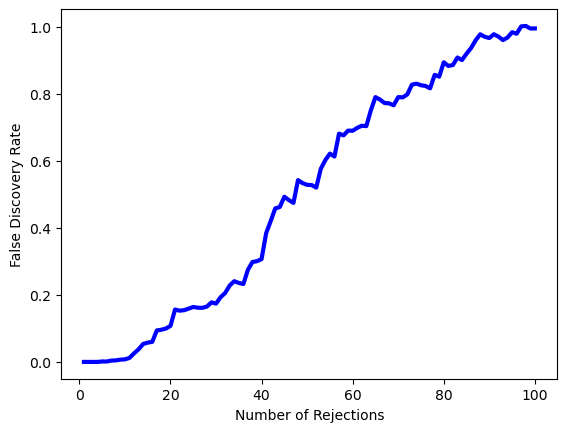

In [32]:
fig, ax = plt.subplots()
ax.plot(Rs, FDRs, 'b', linewidth=3)
ax.set_xlabel("Number of Rejections")
ax.set_ylabel("False Discovery Rate");

In [ ]:
#Applied 7.

In [34]:
Carseats = load_data("Carseats")

In [52]:
qvariables = ["CompPrice", "Income", "Advertising", "Population", "Price", "Age", "Education"]
results = {}
p_values = []

for var in qvariables:
    y = Carseats['Sales']
    X = Carseats[var]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results[var] = model.fit()

    p_value = results[var].pvalues[1] 
    p_values.append(p_value)
    print(f'P-value for the coefficient of {var}: {p_value}')

carseats_pvals = np.array(p_values)

P-value for the coefficient of CompPrice: 0.20093982894183868
P-value for the coefficient of Income: 0.0023096704539518047
P-value for the coefficient of Advertising: 4.3776771103030075e-08
P-value for the coefficient of Population: 0.31398160931904573
P-value for the coefficient of Price: 7.618187011913444e-21
P-value for the coefficient of Age: 2.788949839371399e-06
P-value for the coefficient of Education: 0.2999441527131702


In [ ]:
#b)control the Type I error at level α = 0.05 for the p-values obtained in (a)
#reject Income,Advertising,Price,Age

In [57]:
#c)control the FWER at the level 0.05
#conduct Bonferroni’s method
alpha = 0.05
n_tests = len(carseats_pvals)

reject, bonf = mult_test(carseats_pvals,alpha = alpha / n_tests, method = "bonferroni")[:2]
reject

array([False, False,  True, False,  True,  True, False])

In [59]:
#Advertising, Price, Age(reject True)

In [60]:
#d)
carseats_qvalues = mult_test(carseats_pvals, method = "fdr_bh")[1]

In [61]:
(carseats_qvalues <= 0.2).sum()
#If we control the FDR at 20%
#We find that 4 of the 7 quantitative variables have a q-value below 0.2;

4

In [63]:
carseats_qvalues <= 0.2

array([False,  True,  True, False,  True,  True, False])

In [ ]:
#When the FDR is controlled at level q = 0.2, 4 null hypotheses are rejected

In [ ]:
#Income,Advertising,Price, age

In [66]:
#8)
rng = np.random.default_rng(1)
n, m = 20, 100
X = rng.normal(size=(n, m))

In [69]:
#a one-sample t-test for each of the first  managers in the Fund dataset

fund_pvals = np.empty(m)

for i in range(m):
    fund_pvals[i] = ttest_1samp(X[:, i], 0).pvalue
fund_pvals

array([5.38801264e-02, 2.02572586e-01, 8.56777131e-01, 6.19586963e-01,
       4.66053738e-01, 8.99407380e-01, 6.54314667e-01, 2.51122603e-01,
       2.44481627e-01, 7.79596231e-02, 2.23867120e-01, 1.18753604e-01,
       9.16142811e-01, 2.59936463e-01, 8.06613377e-04, 1.68754852e-01,
       2.24102132e-01, 4.66990660e-01, 9.17115858e-01, 3.24539642e-01,
       7.55006259e-02, 2.26051291e-01, 3.71947638e-01, 5.50363076e-01,
       5.06617712e-01, 1.77938985e-01, 4.95026920e-01, 3.55394796e-02,
       7.86809820e-01, 3.91440181e-01, 5.97764221e-01, 4.93905898e-01,
       9.09168824e-01, 9.03392460e-01, 7.69811614e-01, 8.79382732e-02,
       2.98052636e-01, 3.34499336e-01, 5.86508435e-01, 2.29332821e-02,
       9.69657768e-02, 8.52533463e-01, 1.27961775e-01, 5.23975261e-01,
       9.55121024e-03, 8.74269694e-01, 5.35129668e-01, 3.81090333e-01,
       4.45682897e-01, 3.93321809e-01, 6.56456680e-02, 1.72261062e-01,
       5.53309877e-01, 8.77870665e-01, 7.67945550e-01, 5.28061448e-01,
      

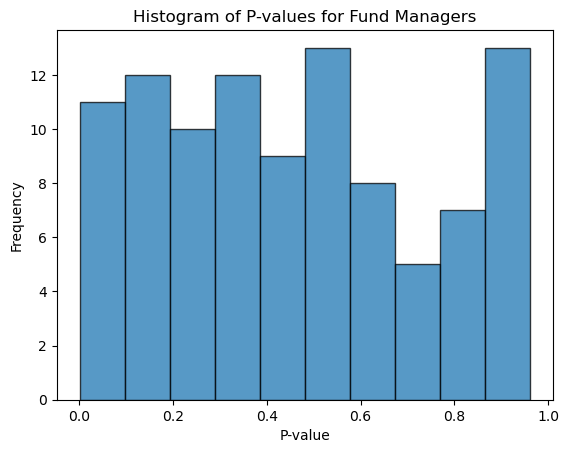

In [70]:
plt.hist(fund_pvals, bins=10, edgecolor='black', alpha=0.75)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of P-values for Fund Managers')
plt.show()

In [75]:
#b)
(fund_pvals<= 0.05).sum()

4

In [ ]:
#how many null hypotheses do we reject? 4

In [73]:
#c)
alpha = 0.05
n_tests = len(fund_pvals)

reject, bonf = mult_test(fund_pvals,alpha = alpha / n_tests, method = "bonferroni")[:2]
reject.sum()

0

In [ ]:
#0

In [77]:
#d)
fund_qvalues = mult_test(fund_pvals, method = "fdr_bh")[1]
(fund_qvalues <= 0.05).sum()

0

In [ ]:
#best performance:smallest p-value

In [93]:
#e)
top_10_indices = np.argsort(fund_pvals)[:10]
top_10_pvals = fund_pvals[top_10_indices]

alpha = 0.05
rejects_fwer, _, _, _ = mult_test(top_10_pvals, alpha=alpha/10, method='bonferroni')
rejected_fwer = np.sum(rejects_fwer)

rejects_fdr= mult_test(top_10_pvals, method = "fdr_bh")[1]
rejected_fdr = (rejects_fdr <= 0.05).sum()


print(f"Number of null hypotheses rejected controlling FWER: {rejected_fwer}")
print(f"Number of null hypotheses rejected controlling FDR: {rejected_fdr}")

Number of null hypotheses rejected controlling FWER: 0
Number of null hypotheses rejected controlling FDR: 2


In [ ]:
# Cherry-picking based on the lowest p-values biases the sample. 
#The p-values associated with these selected managers are no longer representative of random chance across a true null distribution but are the extremes, 
#which misrepresents the general manager population.